# Assumptions of Linear Regression

## By Jean-Philippe Pitteloud

### Requirements

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Data Gathering and Assessment

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con = engine)

engine.dispose()


weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


From the summary table above, it can be seen that the working dataset is composed of 96453 records of hourly weather measurements (12 columns/variables) gathered in the city of Szeged during the period of 2006-2016. Also, the formatting and number of missing records for each variables are described. It is worth noting that all the available variables are complete in terms of missing values

The table displayed below these lines, highlights the summary statistics for all numeric variables in the dataset

In [4]:
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


### Modeling - Linear Regression

Before starting our efforts to develop a model able to predict the 'temperature' based on other parameters recorded in the dataset, the distribution of the target variables in the dataset was explored. The histogram below, shows a distribution that does not look fully normal but close too normality. However, a more detail study is required to draw definitive conclusions

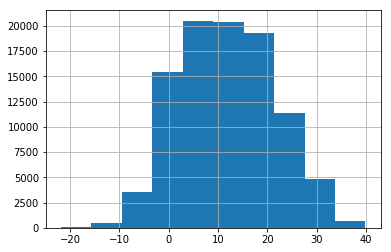

In [5]:
weather_df.temperature.hist();

In order to further study the normality in the distribution of values in the target variable 'temperature', two normality tests were performed and the results shown below. These tests are based on a null hypothesis of the data being normal

To explore the nature of the other variables in the dataset, the following plots were constructed

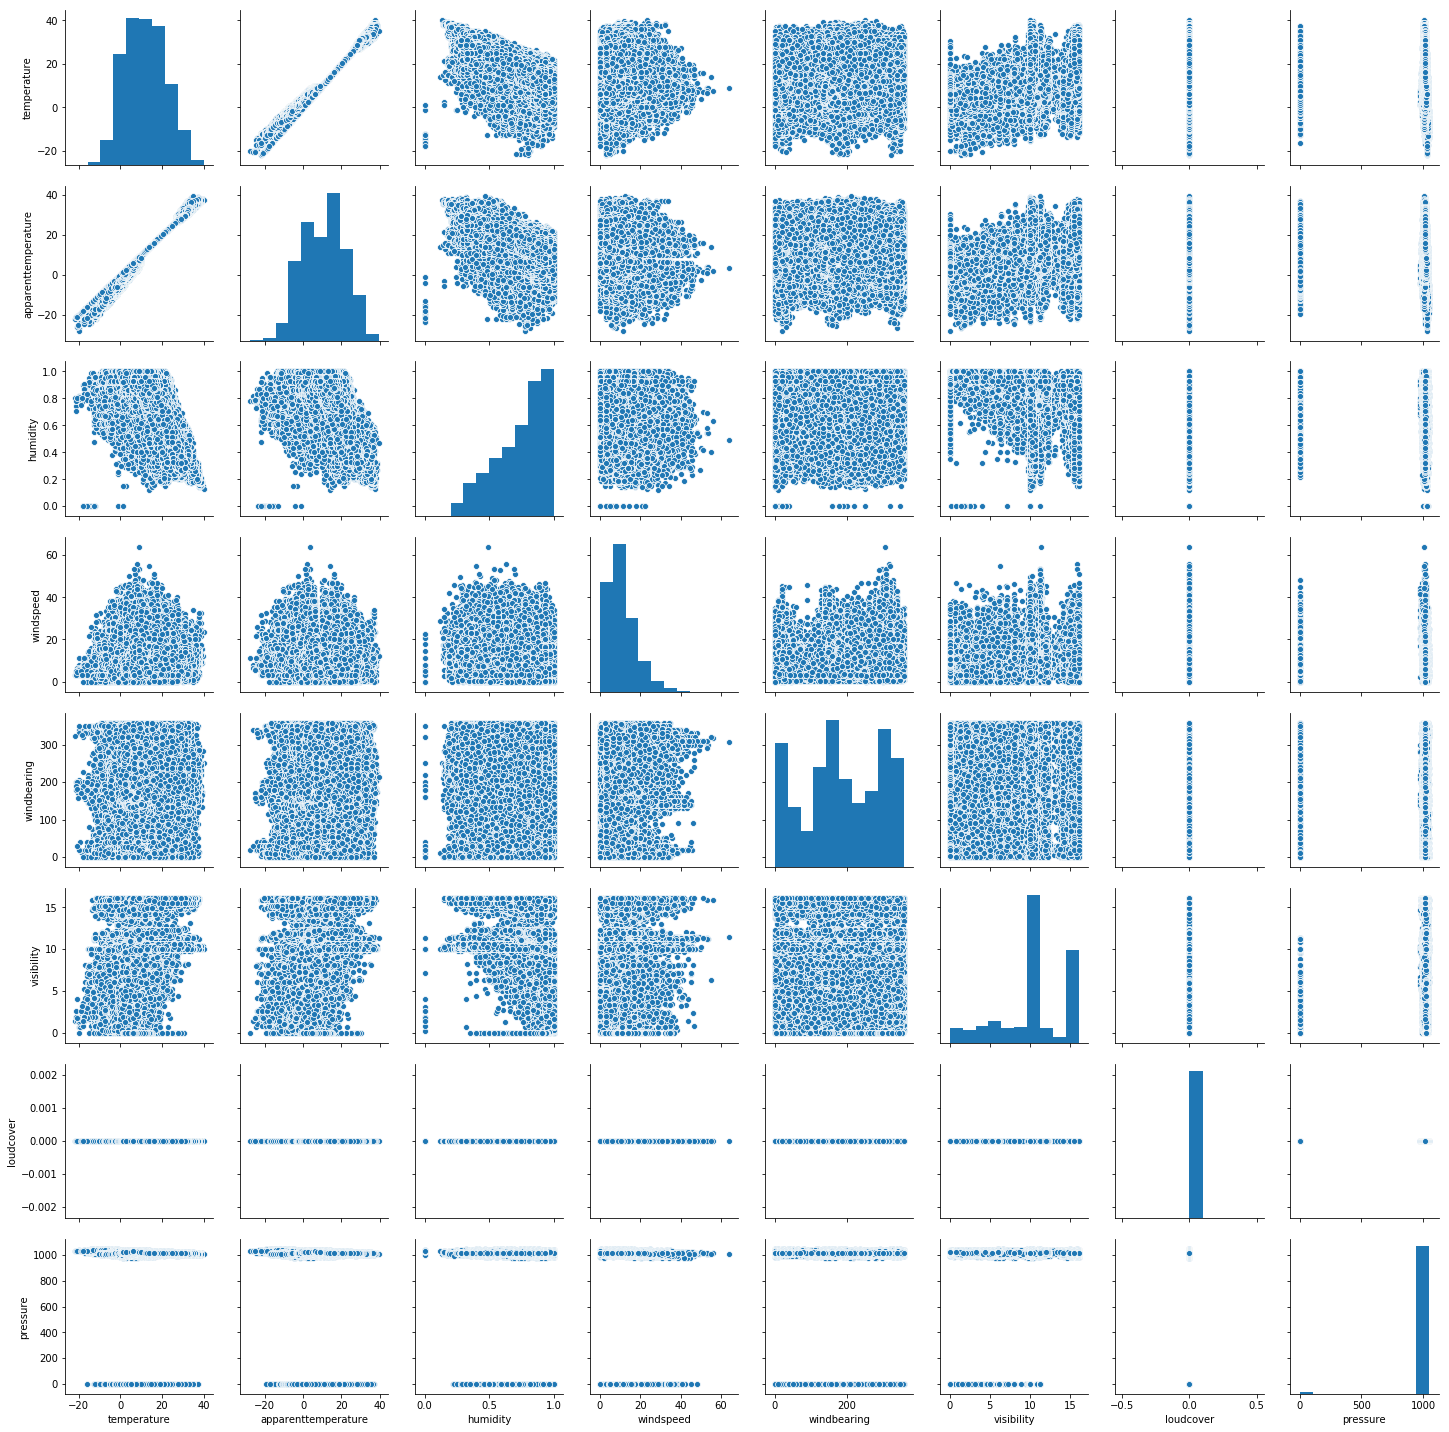

In [6]:
sns.pairplot(weather_df);

From the set of plot displayed above, it can be seen that from the available numeric variables none is normally distributed. Worth noting is the distribution of the values in the variable 'pressure', in which a considerable group of records report a '0' value for pressure. This particular value (0) it is not feasible for weather measurements i a city on earth and likely correspond to misrecordings. In order to further estimate the impact of these values in the variable, the percetage of records with 'pressure' = 0 was calculated

In [7]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(weather_df.temperature)
norm_stats = normaltest(weather_df.temperature)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 1433.6419797355063 and p value is 0.0
Normality test statistics is 2781.3146430107663 and p value is 0.0


In [8]:
(weather_df[weather_df.pressure == 0].shape[0] * 100) / weather_df.shape[0]

1.3353654111328834

Since only a small proportion of the records present values of pressure of '0', the most practical approach is the removal of these records from our working dataset

In [9]:
idx = weather_df[weather_df['pressure'] == 0].index

weather_df.drop(index = idx, inplace = True)

To further confirm the removal of the indicated records, a new histogram of the variable 'pressure' was created and displayed below. The new histograms also reflects a distribution of values close to normality

In [10]:
weather_df.shape[0]

95165

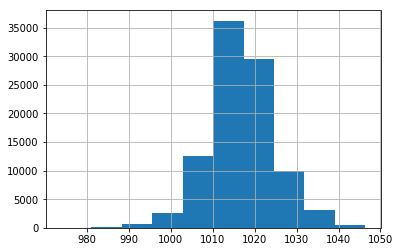

In [11]:
weather_df['pressure'].hist();

The results above, both display numbers that based on the corresponding p-values associated to each test support rejecting the null hypotheses. Therefore, it can be inferred that the values in the variable 'temperature' are not normally distributed

To built our model, the variables 'humidity', 'windspeed', 'windbearing', and 'pressure' were selected as the independent or predictor variables, while 'temperature' was chosen as the dependent or target variable

In [12]:
X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]
Y = weather_df['temperature']

The chosen variables were fitted using a linear regression model using the Ordinary Least Squares statistical method to create our estimator

In [13]:
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.27467869e+01 -3.17826353e-01  2.52552064e-03 -4.17393403e-01]

Intercept: 
 463.38270827696385


The results our modeling efforts using SkLearn library were confirmed using the method available in the statsmodel library

In [14]:
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                 2.668e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        00:18:59   Log-Likelihood:            -3.1395e+05
No. Observations:               95165   AIC:                         6.279e+05
Df Residuals:                   95160   BIC:                         6.280e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         463.3827      2.890    160.341      0.000     457.718     469.047
humidity      -32.7468      0.112   -293.654      0.000     -32.965     -32.528
windspeed      -0.3178      0.003    -96.871      0.000      -0.324      -0.311
windbearing     0.0025      0.000     12.679      0.000       0.002       0.003
pressure       -0.4174      0.003   -147.569      0.000      -0.423      -0.412
==============================================================================
Omnibus:                     3441.751   Durbin-Watson:                   0.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3960.090
Skew:                          -0.450   Prob(JB):                         0.00
Kurtosis:                       3.436   Cond. No.                     1.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the report displayed above, it can be seen that the built linear regression model is able to explain 53% of the variance in the selected data and all the predictors are statistically significant (p-values below 0.05). Also, the coefficients for each of the variables were estimated

### Assumption 1: Linearity of the model in its coefficients

In the following section, the assumptions for the efficient application of a Linear regression model were evaluated. The first assumption tested was the 'Linearity' of the model or the linear relationship of the predictors with the target. A way to test for linearity of the model is a linear relationship between the values of the target variable in the training set and the values predicted for the variables. For this reason, a scatter plot of the "predicted" temperatures against the "actual" temperatures was prepared and displayed below. A trendline was added to the plot to highlight the non-linearity of the relationship between the plotted variables

In [15]:
y_pred = results.predict()

In [16]:
residuals = results.resid

In [17]:
sample_df = pd.DataFrame(data = {'actual': Y, 'predicted': y_pred, 'residuals': residuals}).sample(20000)

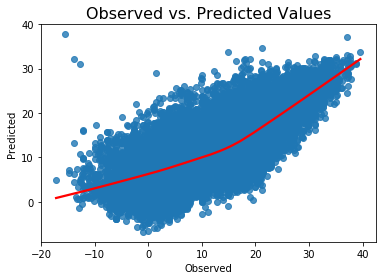

In [18]:
sns.regplot(data = sample_df, x = 'actual', y = 'predicted', lowess = True, line_kws = {'color': 'red'})
plt.title('Observed vs. Predicted Values', fontsize = 16)
plt.ylabel('Predicted')
plt.xlabel('Observed');

Further studying of the linearity of the target and the predictors was explored by plotting the target against each of the predictors. The plots below, suggest a linear relationship for some pairs but very evident lack of linearity between the target 'temperature' and 'pressure' 

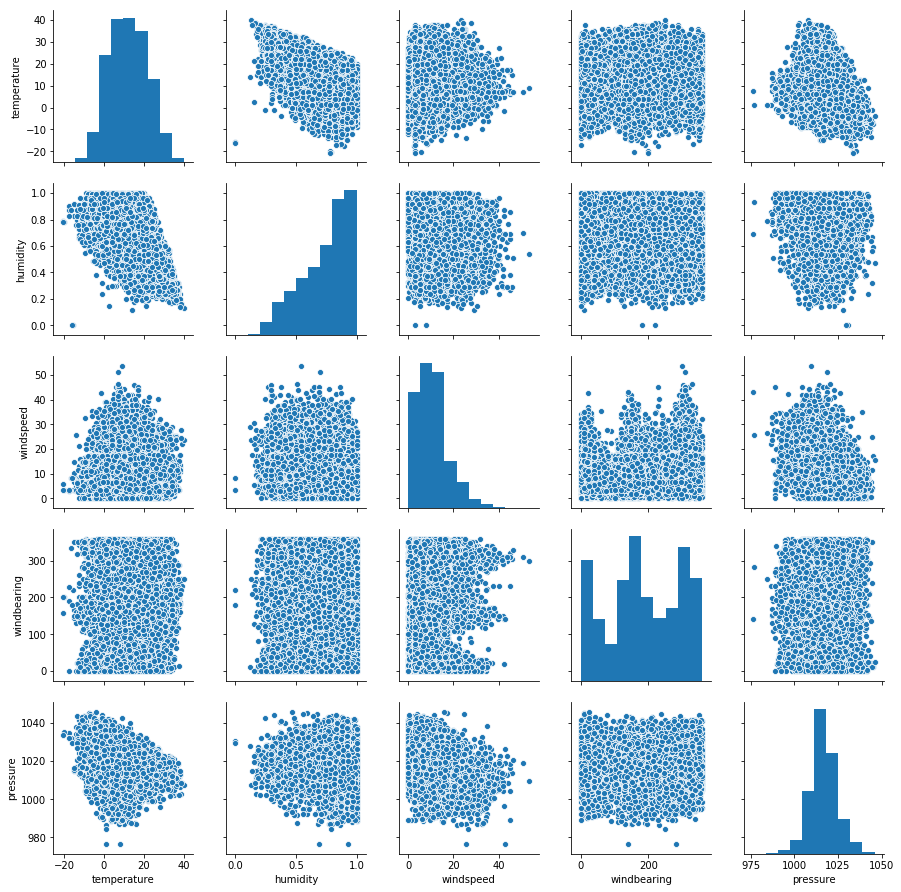

In [19]:
sns.pairplot(data = weather_df[['temperature', 'humidity', 'windspeed', 'windbearing', 'pressure']].sample(20000));

### Assumption 2: the error term should be zero on average

In order to test this assumption, the mean of the residuals or errors was estimated, and the results below reflect a value that can be assumed as '0'

In [20]:
print("Mean of the errors in the medical costs model is: {}".format(np.mean(residuals)))

Mean of the errors in the medical costs model is: -2.5949963346646608e-12


### Assumption 3: homoscedasticity

A model is "homoscedastic" when the distribution of its error terms (known as "scedasticity") is consistent for all predicted values. In other words, the error variance shouldn not systematically change across observations. In order to evaluate the scedasticity of our model, a plot of the predicted temperatures against the errors or residuals was constructed and displayed below. As it can be seen, the residuals are not homogeneously distributed for the predictions made, with smaller errors resulting from predictions with smaller values. On the higher end of the predictions the icurred errors are also lower than the average errors

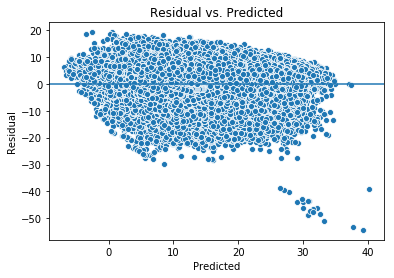

In [21]:
sns.scatterplot(x = y_pred, y = residuals)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y = 0)
plt.title('Residual vs. Predicted');

To further test for "homoscedasticity", two available statistical tests were performed on the residual/errors. Both test are based on the null hypothesis of the data being "homoscedastic"

In [22]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(y_pred, residuals)
lev_stats = levene(y_pred, residuals)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 313.458 and p value is 3.85e-70
Levene test statistic value is 235.663 and p value is 3.74e-53


As it can be seen above, both test yielded numbers that according to the calculated p-values, support the rejection of the null hypothesis. Hence, the results support the conclusion of the model being non "homoscedastic"

### Assumption 4: low multicollinearity

To check for low multicollinearity between the predictor variables used in the model, the "Variance Inflation Factors" (VIF) for such variables was calculated

In [23]:
X.columns

Index(['const', 'humidity', 'windspeed', 'windbearing', 'pressure'], dtype='object')

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [25]:
vif

,VIF Factor,features
0,18503.755432,const
1,1.053951,humidity
2,1.132819,windspeed
3,1.014093,windbearing
4,1.072355,pressure


From the table above, it can be seen that none of the selected variables are associated with significant VIF values. It is worth noting that significant correlation can be assumed with values of VIF above 5. In order to confirm these findings, the correlation matrix of the independent variables was built and displayed below

In [26]:
weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']].corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224282,0.001598,0.039257
windspeed,-0.224282,1.000000,0.101633,-0.253700
windbearing,0.001598,0.101633,1.000000,-0.078687
pressure,0.039257,-0.253700,-0.078687,1.000000


As it can be seen in the table above, none of the variables exhibits significant correlation with others, so the model can be said to satisfy this assumption

### Assumption 5: error terms should be uncorrelated with one another

In order to test for this assumption, a plot of the residuals was created. From the plot, it can be seen that most of the errors are randomized and seem not to be correlated, however, particular areas in the plot (3000 and 5000) exhibit trends in the data

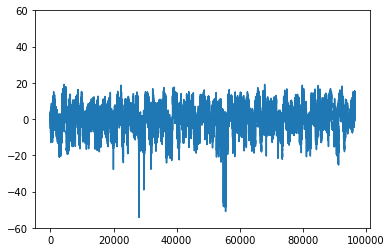

In [27]:
sns.lineplot(data = residuals)
plt.ylim(-60, 60);

To further investigate the errors for autocorrelation, the statsmodel built-in function "acf" was employed and the output plotted. As it can be seen in the plot below, the errors seem to be highly autocorrelated with values ranging from 0.95 to 0.65. Therefore, our linear regression model DOES NOT MEET this assumption

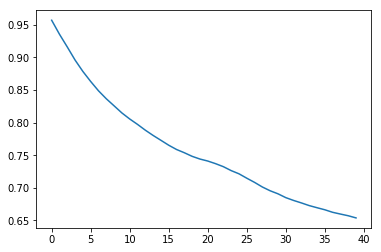

In [28]:
from statsmodels.tsa.stattools import acf

acf_data = acf(residuals)

plt.plot(acf_data[1:]);

### Assumption 6: features shouldn't be correlated with the errors

In an attempt to test for this last assumption, the correlation between the residuals and each of the predictor variables was calculated through a correlation matrix and the results displayed below

In [29]:
weather_df['residuals'] = residuals

In [30]:
weather_df[['residuals', 'humidity', 'windspeed', 'windbearing', 'pressure']].corr()

,residuals,humidity,windspeed,windbearing,pressure
residuals,1.000000e+00,1.010660e-13,-7.860953e-14,-7.138450e-15,5.529022e-15
humidity,1.010660e-13,1.000000e+00,-2.242816e-01,1.597885e-03,3.925713e-02
windspeed,-7.860953e-14,-2.242816e-01,1.000000e+00,1.016334e-01,-2.536997e-01
windbearing,-7.138450e-15,1.597885e-03,1.016334e-01,1.000000e+00,-7.868736e-02
pressure,5.529022e-15,3.925713e-02,-2.536997e-01,-7.868736e-02,1.000000e+00


In the correlation matrix above, none of the variables exhibits correlation with the residuals. In order to confirm these findings, Pearson coefficients were calculated for each independent variables and the residuals accompanied by the corresponding p-values to evaluate their statistical significance. The working null hypothesis in this case is that the tested variables are not correlated with the residuals

In [31]:
from scipy.stats.stats import pearsonr

for column in X.columns:
    corr_test = pearsonr(X[column], residuals)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

Variable: const --- correlation: nan, p-value: 1.0000
Variable: humidity --- correlation: 0.0000, p-value: 1.0000
Variable: windspeed --- correlation: -0.0000, p-value: 1.0000
Variable: windbearing --- correlation: -0.0000, p-value: 1.0000
Variable: pressure --- correlation: 0.0000, p-value: 1.0000


From the result above, it can be concluded that none of the predictor variables are correlated with the residuals (failed to reject the null hypothesis), therefore our model MEETS the assumption of the features used in the model not being correlated with the errors

### Additional assumption

In order to test for an additional useful assumption, the errors were tested for normality by using a Q-Q plot and the corresponding histogram

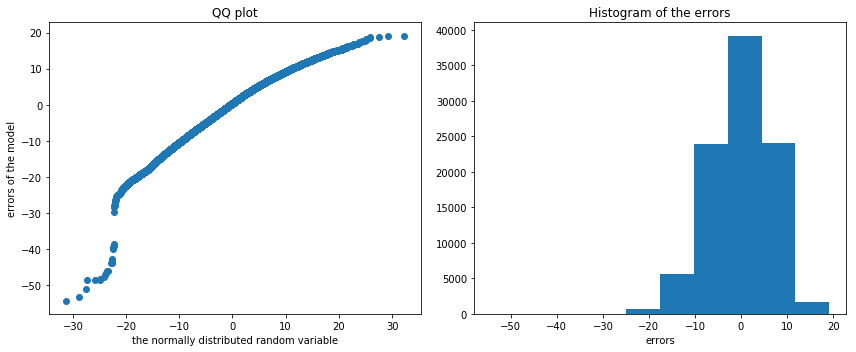

In [32]:
rand_nums = np.random.normal(np.mean(residuals), np.std(residuals), len(residuals))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(residuals)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(residuals)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout();

The two plots above, indicate the errors are distributed quasi normally, however the distribution is left skewed with few errors with highly negative. Also a slight curvature in the Q-Q plot indicates lack of normality

In [33]:
jb_stats = jarque_bera(residuals)
norm_stats = normaltest(residuals)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3960.0902389326798 and p value is 0.0
Normality test statistics is 3441.751245474833 and p value is 0.0


The values obtained from testing the residuals for normality using the Jarque-Bera and 'normaltest' suggest the errors are not normally distributed